In [35]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [36]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [37]:
df2.iloc[:, 9:15]

,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [38]:
c=-1
P_exp=np.array(df2.iloc[:, 12]).reshape([-1,1])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(1, 231399.5)

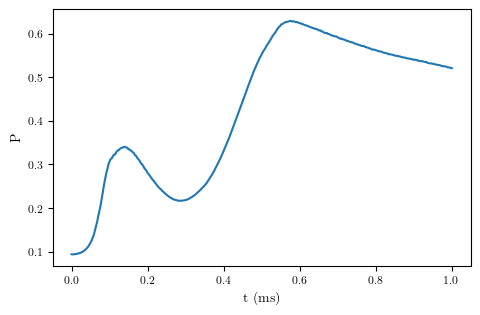

In [39]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [40]:
N_f = 500 # Number of residual point
N_d = 300 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

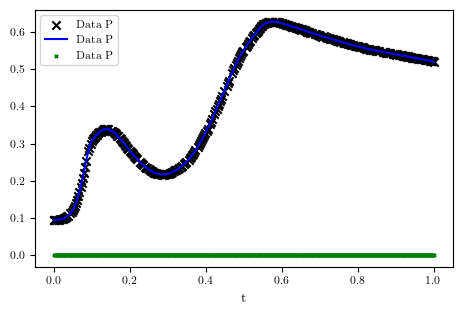

In [41]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.plot(T_star, P_star, color='blue',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [42]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_s = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_a = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, 3), (3, -1))) 


    return alpha_r, alpha_b, alpha_s, alpha_a, alpha_0

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi_1, b_phi_1, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp1=u[:,0:1]
        lnp2=u[:,1:2]
        lns=u[:,2:3]

        p1=tf.exp(lnp1)
        p2=tf.exp(lnp2)
        s=tf.exp(lns)

        lnphi11=net(tf.concat([p1, s],1), W_phi_1, b_phi_1)
        phi11=tf.exp(lnphi11)
        lnphi12=net(tf.concat([p2, s],1), W_phi_1, b_phi_1)
        phi12=tf.exp(lnphi12)



        # beta=tf.exp(lnv[0:1])
        # gamma=tf.exp(lnv[1:2])
        delta1=tf.exp(lnv[0:1])
        delta2=tf.exp(lnv[1:2])
        m=tf.exp(lnv[2:3])


  
    p1_t = tape1.gradient(p1, t) 
    p2_t = tape1.gradient(p2, t) 
    s_t = tape1.gradient(s, t) 

    f_p1 = p1_t - (phi11*p1*s -delta1*p1)
    f_p2 = p2_t - (phi12*p2*s -delta2*p2)
    f_s = s_t - (- m*p1 - m*p2)*s
    
    return f_p1, f_p2, f_s


#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi_1,b_phi_1, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    t_0 = tf.concat([tf.zeros([1, 1], dtype=tf.float32), tf.ones([1, 1], dtype=tf.float32)], axis=0)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi_1, b_phi_1, lambda_r,lambda_0, lambda_s, lnv])
        u_nn = net(t_u, W_p, b_p) 
        lnp1=u_nn[:,0:1]
        lnp2=u_nn[:,1:2]

        p1_nn=tf.exp(lnp1)
        p2_nn=tf.exp(lnp2)

        f_p1, f_p2, f_s= net_f(t_f, W_p, b_p, W_phi_1, b_phi_1, lnv)


        u_00 = net(t_0, W_p, b_p) 
        lnp2_0=u_00[0:1,1:2]
        lns_0=u_00[:,2:3]
        p2_00=tf.exp(lnp2_0)
        s_00=tf.exp(lns_0)

        loss_p = tf.square(lambda_b*(p1_nn + p2_nn - p_train_tf))
        loss_0 = tf.square(lambda_0[0:1]*(p2_00 - 0))
        loss_0 = tf.square(lambda_0[1:]*(s_00 - tf.concat([tf.ones([1, 1], dtype=tf.float32), tf.zeros([1, 1], dtype=tf.float32)], axis=0)))
        loss_fp1 = tf.square(lambda_r[0:1]*f_p1) 
        loss_fp2 = tf.square(lambda_r[1:2]*f_p2) 
        loss_fs = tf.square(lambda_s*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0)  

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi_1 = tape.gradient(loss, train_vars(W_phi_1, b_phi_1))
    # grads_phi_2 = tape.gradient(loss, train_vars(W_phi_2, b_phi_2))


    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_s = tape.gradient(loss, lambda_s)
    grads_0 = tape.gradient(loss, lambda_0)
    grads_lnv = tape.gradient(loss, lnv)


    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_s], [lambda_s]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))
    opt.apply_gradients(zip([grads_lnv], [lnv]))
  

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi_1, train_vars(W_phi_1, b_phi_1)))
    # opt.apply_gradients(zip(grads_phi_2, train_vars(W_phi_2, b_phi_2)))


   
    return loss, tf.reduce_mean(tf.square((p1_nn+p2_nn - p_train_tf))), tf.reduce_mean(tf.square(f_p1)), tf.reduce_mean(tf.square(f_s))



layers = [1, 20, 20, 20, 3]
L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 50, 50, 50, 1]
L = len(layers)
W_phi_1= [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_1 = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [1, 20, 20, 1]

# W_phi_2= [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_phi_2 = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


lambda_r, lambda_b, lambda_s, lambda_a, lambda_0 = loss_weight(N_f, N_d)
lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 3), (3, -1)), dtype=tf.float32) 


@tf.function()
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred


In [ ]:
lr = 1e-3
# Nmax = 15000
# Nmax = 150000
Nmax=3*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_1, b_phi_1,  T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_1, b_phi_1,  T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p,  W_phi_1,b_phi_1, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv, optimizer)


while n <= Nmax:
    if n<2*10**4:
        loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi_1, b_phi_1, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv)
    elif n< 10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi_1, b_phi_1,  T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi_1, b_phi_1,  T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 3604866.25
Data loss is: 2.640512466430664
Physicial loss of p is: 5.77836799621582
Physicial loss of s is: 46.755393981933594
Iteration is: 10
Total loss is: 2392860.0
Data loss is: 2.038416624069214
Physicial loss of p is: 0.8804966807365417
Physicial loss of s is: 20.116628646850586
Iteration is: 20
Total loss is: 1470736.125
Data loss is: 1.167729377746582
Physicial loss of p is: 0.6964660286903381
Physicial loss of s is: 8.934540748596191
Iteration is: 30
Total loss is: 604713.125
Data loss is: 0.4310283362865448
Physicial loss of p is: 0.6285436153411865
Physicial loss of s is: 2.8547511100769043
Iteration is: 40
Total loss is: 161548.5625
Data loss is: 0.0768500417470932
Physicial loss of p is: 0.507042407989502
Physicial loss of s is: 0.2898065447807312
Iteration is: 50
Total loss is: 56256.203125
Data loss is: 0.01627621240913868
Physicial loss of p is: 0.34986674785614014
Physicial loss of s is: 0.018273498862981796
Iteration is: 60
Total loss i

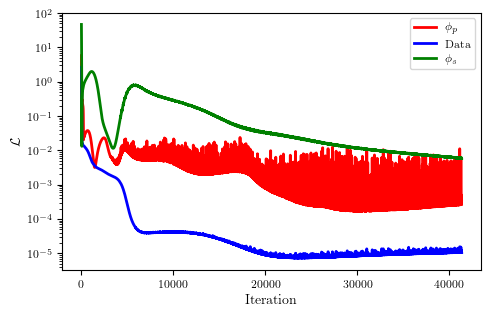

In [21]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]
loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
# Nreg=len(loss_reg)
# it_r = np.arange(0,Nmax- Nmax%10000 +1, 10000)

# loss_reg_list = [loss_reg[i].numpy() for i in range(0,Nreg)]

# loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, label = '$\phi_p$') 

plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  

plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, label = '$\phi_s$')  
# plt.semilogy(it_r, np.asarray(loss_reg_list), 'black', linewidth = 2, label = '$\phi_r$')    


# plt.semilogy(it, np.asarray(loss_phia_list), 'y-', linewidth = 2, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [22]:
lnv[0], tf.exp(lnv[0]), lnv[1], tf.exp(lnv[1])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.1878343], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.915882], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.1926935], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.9593115], dtype=float32)>)

In [31]:


## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp1=u_pred[:,0:1]
lnp2=u_pred[:,1:2]
lns=u_pred[:,2:3]


p1=tf.exp(lnp1)
p2=tf.exp(lnp2)
s=tf.exp(lns)

delta1=tf.exp(lnv[0:1])
delta2=tf.exp(lnv[1:2])
m=tf.exp(lnv[2:3])



lnphi11 = predict(tf.concat([p1, s],1), W_phi_1, b_phi_1)
lnphi12 = predict(tf.concat([p2, s],1), W_phi_1, b_phi_1)
# lnphi2 = predict(s, W_phi_2, b_phi_2)

phi11=tf.exp(lnphi11)
phi12=tf.exp(lnphi12)
# phi2=tf.exp(lnphi2)

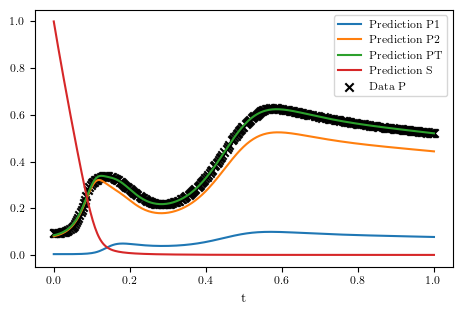

In [24]:
plt.plot(T_star_tf, p1, label='Prediction P1')
plt.plot(T_star_tf, p2, label='Prediction P2')
plt.plot(T_star_tf, p1+p2, label='Prediction PT')

plt.plot(T_star_tf, s, label='Prediction S')




# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

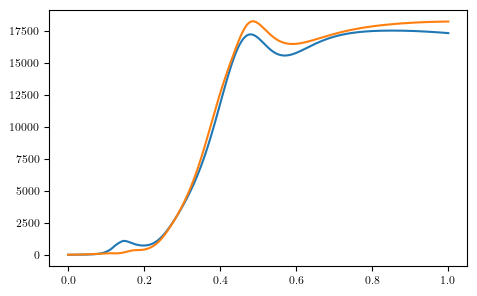

In [25]:
plt.plot(T_star_tf, phi11, label='Prediction P')
plt.plot(T_star_tf, phi12, label='Prediction P')



In [26]:
# plt.plot(T_star_tf, phi2, label='Prediction P')


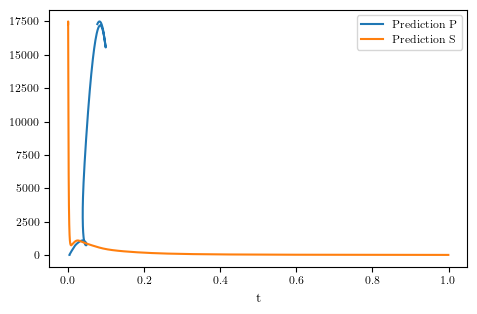

In [27]:
plt.plot( p1, phi11,label='Prediction P')
plt.plot( s, phi11, label='Prediction S')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

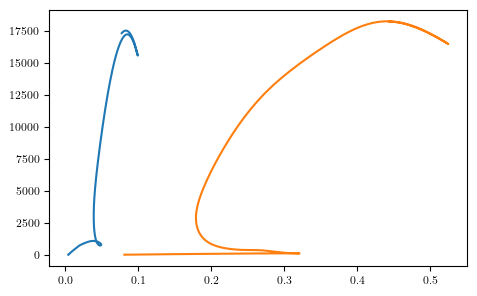

In [28]:
plt.plot( p1,  phi11,label='Prediction P')
plt.plot( p2,  phi12,label='Prediction P')


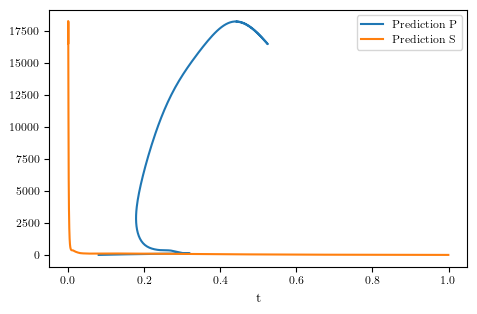

In [29]:
plt.plot( p2,  phi12,label='Prediction P')


plt.plot( s, phi12, label='Prediction S')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [ ]:
# plt.plot( s, phi2, label='Prediction S')

# plt.legend()
# plt.xlabel('t')
# # plt.ylabel('P')
# # plt.savefig('figures/P_phi.pdf')
# plt.show()

In [32]:
Nt=1000
T_int=np.zeros(Nt)
P1_int=np.zeros(Nt)
P2_int=np.zeros(Nt)
S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P1_int[0]=np.array(p1[0]) #Initial conditions

P2_int[0]=np.array(p2[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions


# m=0.3

for i in range(1,Nt):

    # PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P1S=tf.concat([tf.convert_to_tensor(P1_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P2S=tf.concat([tf.convert_to_tensor(P2_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI11=tf.exp(predict(P1S , W_phi_1, b_phi_1))
    PHI12=tf.exp(predict(P2S , W_phi_1, b_phi_1))
    # PHI2=tf.exp(predict( tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), W_phi_2, b_phi_2))

    # P1_int[i]=P1_int[i-1]+(PHI11*S_int[i-1]*P1_int[i-1] - PHI2*P1_int[i-1]-delta1*P1_int[i-1])*dt
    # P2_int[i]=P2_int[i-1]+(PHI12*S_int[i-1]*P2_int[i-1] + PHI2*P1_int[i-1]-delta2*P2_int[i-1])*dt
    P1_int[i]=P1_int[i-1]+(PHI11*S_int[i-1]*P1_int[i-1] -delta1*P1_int[i-1])*dt
    P2_int[i]=P2_int[i-1]+(PHI12*S_int[i-1]*P2_int[i-1] -delta2*P2_int[i-1])*dt
    S_int[i]=S_int[i-1]-(m*P1_int[i-1]+m*P2_int[i-1])*S_int[i-1]*dt
    T_int[i]=T_int[i-1]+dt

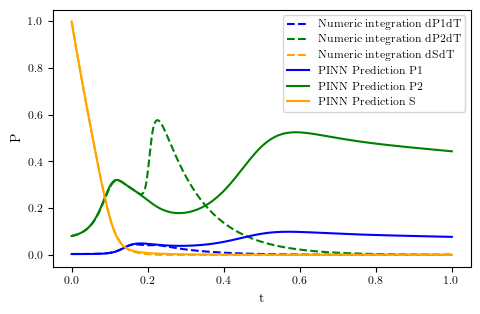

In [33]:
plt.plot(T_int, P1_int, color='blue', linestyle='--', label='Numeric integration dP1dT')
plt.plot(T_int, P2_int, color='green', linestyle='--', label='Numeric integration dP2dT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

# plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p1, color='blue', label='PINN Prediction P1')
plt.plot(T_star_tf, p2,color='green', label='PINN Prediction P2')

plt.plot(T_star_tf, s,color='orange', label='PINN Prediction S')

# plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

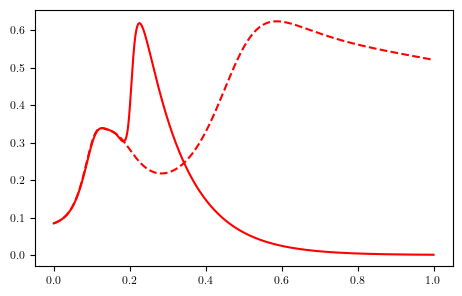

In [34]:
plt.plot(T_int, P1_int+P2_int, color='red', label='Numeric integration dSdT')
plt.plot(T_star_tf, p1+p2, color='red', linestyle='--', label='Numeric integration dSdT')
plt.show()


# Symbolic Regresion

In [89]:
phi=np.vstack([phi11, phi12])
ps=np.vstack([np.hstack([p1, s]),np.hstack([p2, s])]) 

In [83]:
ps.shape, phi1.shape

((684, 2), (684, 1))

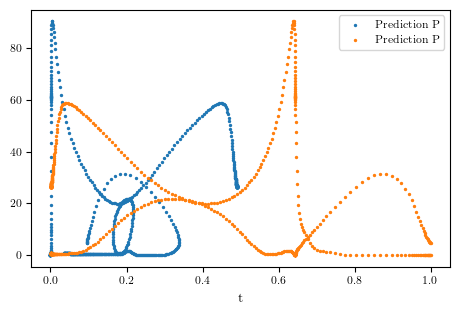

In [90]:
c=0
d=-1
plt.scatter( ps[...,0:1], phi, s=2, label='Prediction P')
plt.scatter( ps[...,1:2], phi, s=2, label='Prediction P')

# plt.scatter( s[c:d], phi_ps[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
# X_star_tf[c:d][0], X_star_tf[c:d][-1]

In [88]:
# Create and train the PySR model
model_phip = PySRRegressor(
    niterations=500,
    binary_operators=["+", "*", "/"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    constraints={"mult": (1, 2)},
    # complexity_of_operators={"/": 2},
    parsimony=0.1,
    # denoise=True,
    complexity_of_variables=2,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    # maxsize=25,
)

In [91]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# ps=tf.concat([p, s], axis=1)


max_cols_phi = tf.math.reduce_max(phi, axis=0)
min_cols_phi = tf.math.reduce_min(phi, axis=0)
phi_scaled = (phi-min_cols_phi)/(max_cols_phi-min_cols_phi)

model_phip.fit(ps,phi_scaled)
print(model_phip)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.300e+05
Head worker occupation: 22.4%
Progress: 534 / 7500 total iterations (7.120%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           5.763e-02  1.594e+01  y = 0.2143
6           5.380e-02  1.376e-02  y = -0.12197 / (x₀ + -0.85144)
7           5.336e-02  8.286e-03  y = 0.13798 + (x₀ * x₀)
9           5.158e-02  1.700e-02  y = ((x₀ + -0.23687) * x₀) + 0.18996
11          5.058e-02  9.784e-03  y = 0.18996 + (((x₀ + -0.25196) * x₀) / 0.67249)
12          4.880e-02  3.573e-02  y = (x₀ + x₁) / ((x₁ / 0.24261) + 1.2844)
14          4.403e-02  5.143e-02  y = (x₁ * 0.42049) + (((x₁ + -0.36502) * x₀) / -0.48205)
16          4.402e-02  1.058e-04  y = (x₁ * 0.42049) + (((x₁ + (-0.36502 * 0.9896)) * x₀) / -0.4...
                                  8205)
17          4.312e-02  2.063e-02  y = (((x₁ + -0.31104) * x₀) / -0.53701) + (x₁ / (1.7099 + x

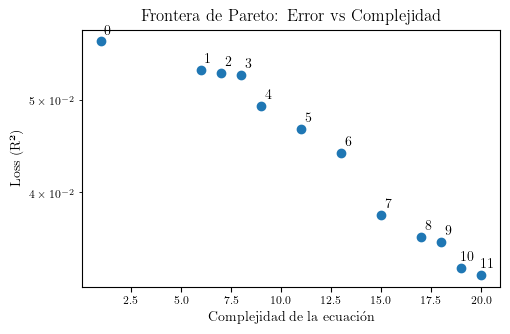

In [93]:
# Extraer las métricas de las ecuaciones
equations_df = model_phip.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

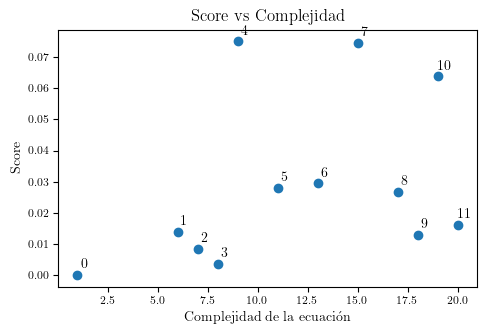

In [94]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [99]:
chose=11
expr=model_phip.sympy(chose)
expr
sympy.expand(expr)

-2.8371212*x0*x1 + 0.6727456*x0 - 1.4185606*x1**2 + 1.57325704498302*x1

In [100]:
sympy.simplify(expr)


0.6727456*x0 - 1.4185606*x1*(2*x0 + x1 - 1.1090517)

In [101]:
sympy.factor(expr)


-2.8371212*(1.0*x0*x1 - 0.237122615699322*x0 + 0.5*x1**2 - 0.55452585*x1)

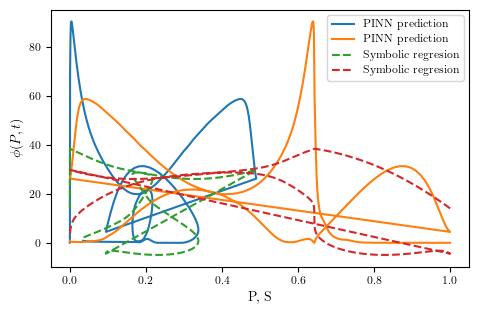

In [102]:
symb1=model_phip.predict(ps,chose)*(max_cols_phi-min_cols_phi)+min_cols_phi
plt.plot(ps, phi, label='PINN prediction')
plt.plot(ps, symb1, linestyle='--', label='Symbolic regresion')
# plt.plot(tf.concat([p, s],1), 15.38-1.18*s, linestyle='--', label=r'$s\approx 0$')


plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.legend()
plt.show()

In [363]:
p[0],s[0]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01044814], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9996284], dtype=float32)>)

In [364]:
Nt=1000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)
# A_symb=np.zeros(Nt)


dt=0.001

# P_symb[0]=np.mean(uu1) #Initial conditions
P_symb[0]=np.array(p[0])  #Initial conditions
S_symb[0]=np.array(s[0]) #Initial conditions
# A_symb[0]=np.array(a[0])  #Initial conditions
T_symb[0]=0

for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI=model_phip.predict(PS_p,chose)*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb[i]=P_symb[i-1]+PHI*P_symb[i-1]*S_symb[i-1]*dt
    S_symb[i]=S_symb[i-1]-PHI*P_symb[i-1]*S_symb[i-1]*dt
    T_symb[i]=T_symb[i-1]+dt

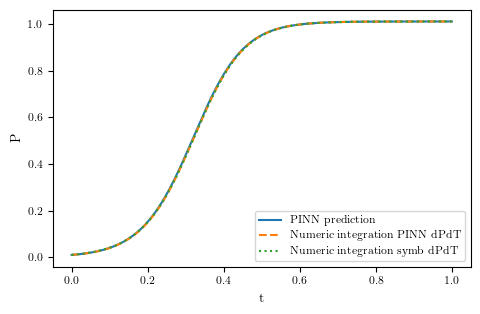

In [365]:
plt.plot(T_star_tf, p, label='PINN prediction')
plt.plot(T_int, P_int, linestyle='--', label='Numeric integration PINN dPdT')
plt.plot(T_symb, P_symb, linestyle=':', label='Numeric integration symb dPdT')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

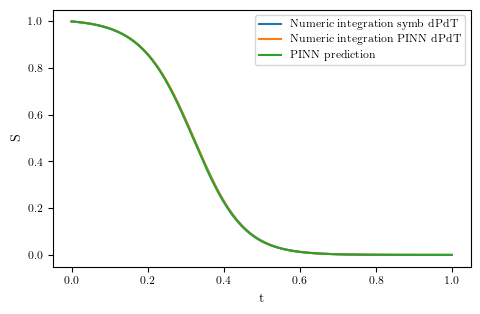

In [366]:
plt.plot(T_symb, S_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()

In [ ]:
# plt.plot(T_symb, A_symb, label='Numeric integration symb dPdT')
# plt.plot(T_int, A_int, label='Numeric integration PINN dPdT')
# plt.plot(T_star_tf, a, label='PINN prediction')
# plt.xlabel('t')
# plt.ylabel('A')
# plt.legend()
# plt.show()

# Quitamos los bordes

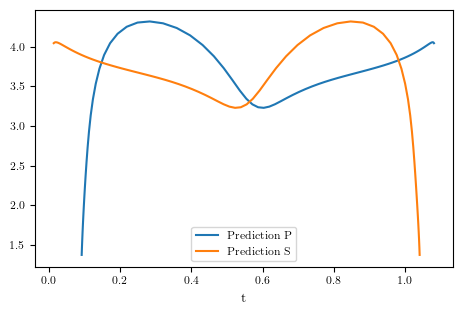

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1549298], dtype=float32)>)

In [157]:
c=0
d=-420
plt.plot( p[c:d], tf.math.log(phi)[c:d],label='Prediction P')
plt.plot( s[c:d], tf.math.log(phi)[c:d], label='Prediction S')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
T_star_tf[c:d][0], T_star_tf[c:d][-1]

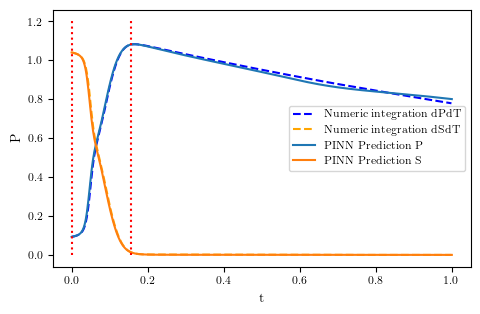

In [158]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

# plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s, label='PINN Prediction S')
plt.vlines(T_star_tf[c:d][0],0,1.2, color='red', linestyle=':')
plt.vlines(T_star_tf[c:d][-1],0,1.2, color='red', linestyle=':')

# plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [180]:
# # Create and train the PySR model
# model = PySRRegressor(
#     niterations=500,
#     binary_operators=["+", "*", "/"],
#     # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
#     # unary_operators=["inv(x) = 1/x"],
#     # extra_sympy_mappings={"inv": lambda x: 1/x},
#     constraints={"mult": (1, 2)},
#     # complexity_of_operators={"/": 2},
#     parsimony=0.1,
#     denoise=True,
#     complexity_of_variables=2,
#     elementwise_loss="loss(prediction, target) = (prediction - target)^2",
#     random_state=42,   # Fija la semilla
#     maxsize=25,
# )

# Create and train the PySR model
model = PySRRegressor(
    niterations=500,
    # binary_operators=["+", "*", "/"],
    binary_operators=["+", "*", "/"],

    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    constraints={"mult": (1, 2)},
    # complexity_of_operators={"/": 2},
    parsimony=0.001,
    # denoise=True,
    complexity_of_variables=2,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    select_k_features=1,
    # maxsize=35,
)

In [181]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ps=tf.concat([p[c:d], s[c:d]], axis=1)

max_cols_phi = tf.math.reduce_max(phi[c:d], axis=0)
min_cols_phi = tf.math.reduce_min(phi[c:d], axis=0)
phi_scaled = (phi[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)

model.fit(ps,phi_scaled)
print(model)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Using features ['x0']

Expressions evaluated per second: 3.080e+05
Head worker occupation: 23.0%
Progress: 699 / 7500 total iterations (9.320%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.729e-02  1.594e+01  y = 0.49621
3           6.729e-02  -0.000e+00  y = 0.6231 * 0.79626
6           3.911e-02  1.809e-01  y = 0.66228 + (-0.048982 / x0)
8           3.194e-02  1.012e-01  y = (-0.0087718 / (x0 + -0.080424)) + 0.62111
10          3.150e-02  6.995e-03  y = 0.6027 + (-0.0087718 / (-0.076983 + (x0 * 0.9593)))
11          2.671e-02  1.647e-01  y = 0.43094 + (((-0.01716 / x0) + 0.13686) / x0)
14          1.820e-02  1.280e-01  y = -0.80785 + (x0 + (((-0.039309 / x0) + 0.47089) / x0))
16          1.510e-02  9.316e-02  y = (x0 + -0.97446) + (((-0.051381 / x0) + 0.66559) / (x0 + 0....
                                  065275))
17          1.276e-02  1.683e-01  y = (1.8021

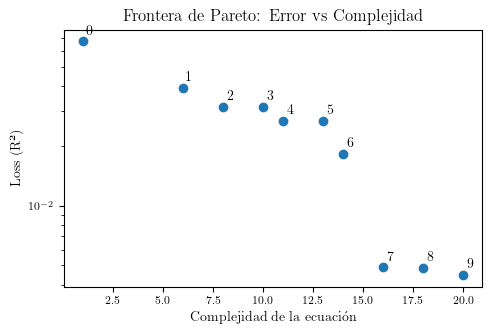

In [182]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

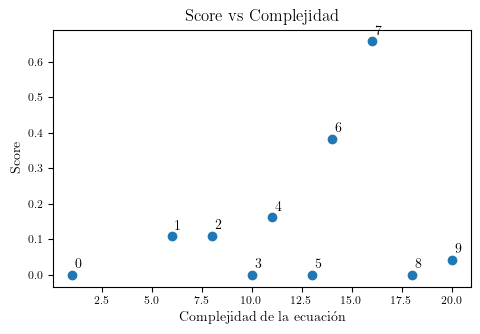

In [183]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [229]:
chose=9
expr=model.sympy(chose)*(max_cols_phi-min_cols_phi)+min_cols_phi
expr
sympy.expand(expr)

349.015553104732*x0**2 - 585.378445826205*x0 + 319.92986486826 - 38.3977894344399/(x0 + 0.049884707)

In [230]:
sympy.simplify(expr)


((x0 + 0.049884707)*(90.5158650784302*x0*(3.8558495*x0 - 6.4671364) + 319.92986486826) - 38.3977894344399)/(x0 + 0.049884707)

In [231]:
sympy.factor(expr)


567.967907221132*(0.614498721965372*x0**3 - 1.0*x0**2 + 0.511874753692575*x0 - 0.0395060734588321)/(1.0*x0 + 0.049884707)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(


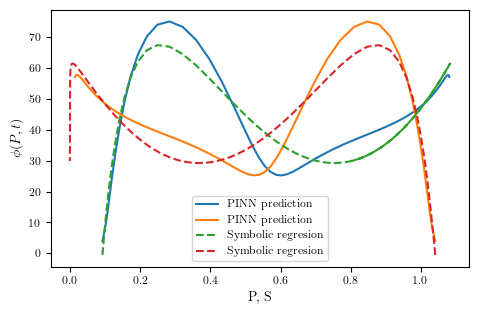

In [232]:
symb1=model.predict(tf.concat([p, s],1),chose)
symb1=symb1*(max_cols_phi-min_cols_phi)+min_cols_phi
plt.plot(tf.concat([p[c:d], s[c:d]],1), phi[c:d], label='PINN prediction')
plt.plot(tf.concat([p, s],1), symb1, linestyle='--', label='Symbolic regresion')
# plt.plot(tf.concat([p, s],1), 15.38-1.18*s, linestyle='--', label=r'$s\approx 0$')

# plt.plot( s, 200/(13+s), label='Real S')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.legend()
plt.show()

In [233]:
Nt=1000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)
# A_symb=np.zeros(Nt)


dt=0.001

# P_symb[0]=np.mean(uu1) #Initial conditions
P_symb[0]=np.array(p[0])  #Initial conditions
S_symb[0]=np.array(s[0]) #Initial conditions
# A_symb[0]=np.array(a[0])  #Initial conditions
P_symb[0]=np.array(0.098)  #Initial conditions
# S_symb[0]=np.array(s[0]) #Initial conditions
T_symb[0]=0

for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI=model.predict(PS_p,chose)*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb[i]=P_symb[i-1]+(PHI*S_symb[i-1]-m)*P_symb[i-1]*dt
    S_symb[i]=S_symb[i-1]-PHI*P_symb[i-1]*S_symb[i-1]*dt
    T_symb[i]=T_symb[i-1]+dt

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packa

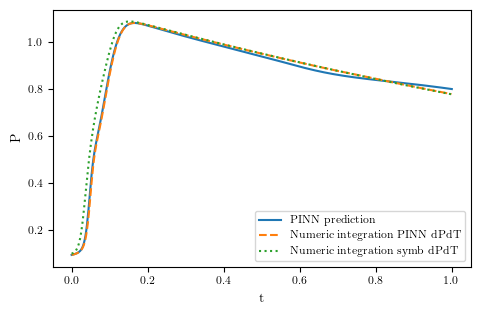

In [234]:
plt.plot(T_star_tf, p, label='PINN prediction')
plt.plot(T_int, P_int, linestyle='--', label='Numeric integration PINN dPdT')
plt.plot(T_symb, P_symb, linestyle=':', label='Numeric integration symb dPdT')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

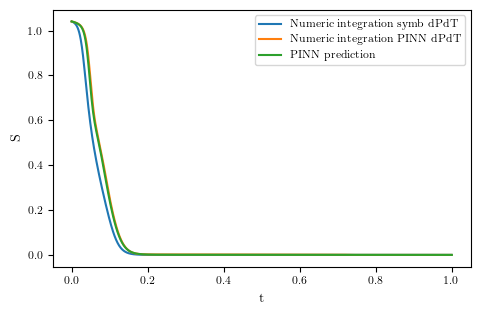

In [235]:
plt.plot(T_symb, S_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()